# Relative Elevation Model Visualization

Credit to:
- Author: [Dahn](https://twitter.com/DahnJahn)
- Based on "[Creating REMs in QGIS with the IDW Method](https://dancoecarto.com/creating-rems-in-qgis-the-idw-method)" by [Dan Coe](https://twitter.com/geo_coe)
- This tutorial re-creates the [Ivalo River Geomorphology](https://dancoecarto.com/ivalo-river-geomorphology) visualization

In this tutorial, we create a **Relative Elevation Model** (**REM**) in Python using [xarray](https://docs.xarray.dev/en/stable/).

A REM is created by subtracting the river's elevation from a **Digital Elevation Model**, displaying the **height above river**. This makes the river's [meanders](https://en.wikipedia.org/wiki/Meander) more visible.

![](https://i.imgur.com/aVHm3yC.png)

([image source](https://ngmdb.usgs.gov/Info/dmt/docs/DMT16_Coe.pdf))

# Step 0: Setup

### Imports

In [118]:
import os
import glob
from pathlib import Path
from IPython.core.display import Video

import numpy as np
import pandas as pd
import geojson
import geopandas as gpd  # Vector data handling
import osmnx as ox       # Downloading data from OSM

from shapely.geometry import box, LineString, Polygon, mapping
from shapely.ops import unary_union, linemerge
from scipy.spatial import cKDTree as KDTree # For Inverse Distance Weight calculation

import xarray as xr    
import xrspatial    # Hillshading
import rioxarray    # Working with geospatial data in xarray

import matplotlib.pyplot as plt
import datashader as ds
from datashader.transfer_functions import shade, stack, Images
from datashader.utils import export_image
from datashader.colors import Greys9, inferno

In [119]:
BASE_PATH = os.getcwd()
DATA_PATH = os.path.join(BASE_PATH, 'data')
DEM_PATH = glob.glob(os.path.join(DATA_PATH, 'bogor', "*.tif"))

# PREDEFINED VARIABLES
ORIGINAL_CRS = 4326
PROJECTED_CRS = 3857  # WGS84 Web Mercator (Auxiliary Sphere)

## Functions

In [120]:
def projected_buffer(
        gdf: gpd.GeoDataFrame,
        buffer_radius: float | int
) -> gpd.GeoDataFrame:
    """
    Buffer the geometries using unit in meters
    """
    if gdf.crs.is_projected:
        gdf['geometry'] = gdf.buffer(buffer_radius)
    else:
        # need to convert to projected crs first
        # to make the buffer unit in meter
        gdf_proj = gdf.to_crs(PROJECTED_CRS)
        gdf_proj['geometry'] = gdf_proj.buffer(buffer_radius)
        gdf = gdf_proj.to_crs(ORIGINAL_CRS)
    return gdf

## Step 1: Load DEM

In [166]:
# # import single tif
# dem = rioxarray.open_rasterio(DEM_PATH[2])

# import multiple tif 
dem = xr.combine_by_coords([rioxarray.open_rasterio(dem) for dem in DEM_PATH])
dem = dem.to_array()

dem.rio.write_crs(ORIGINAL_CRS, inplace=True)

# # We will make the DEM smaller so that it's easier to work with
# dem = dem.coarsen(x=3, boundary='trim').mean().coarsen(y=3, boundary='trim').mean()

<xarray.DataArray (variable: 1, band: 1, y: 9999, x: 6666)>
array([[[[  -3.3402865,   -3.3402662,   -3.3402462, ...,   -3.1909268,
            -3.189832 ,   -3.1886587],
         [  -3.3403063,   -3.340286 ,   -3.340266 , ...,   -3.1911044,
            -3.1900353,   -3.1888893],
         [  -3.340326 ,   -3.3403058,   -3.3402858, ...,   -3.1912737,
            -3.1902304,   -3.189112 ],
         ...,
         [1406.816    , 1405.8218   , 1404.4408   , ..., 1547.9862   ,
          1547.9622   , 1548.0968   ],
         [1409.3473   , 1408.3999   , 1407.0951   , ..., 1550.5763   ,
          1550.2933   , 1550.2688   ],
         [1411.3868   , 1410.5308   , 1409.3273   , ..., 1552.2654   ,
          1551.8292   , 1551.6981   ]]]], dtype=float32)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 106.5 106.5 106.5 106.5 ... 107.0 107.0 107.0 107.0
  * y            (y) float64 -6.0 -6.0 -6.0 -6.0 ... -6.75 -6.75 -6.75 -6.75
  * variable     (variable) object 'z'
    spatial_ref  int32 0

Let's plot the DEM

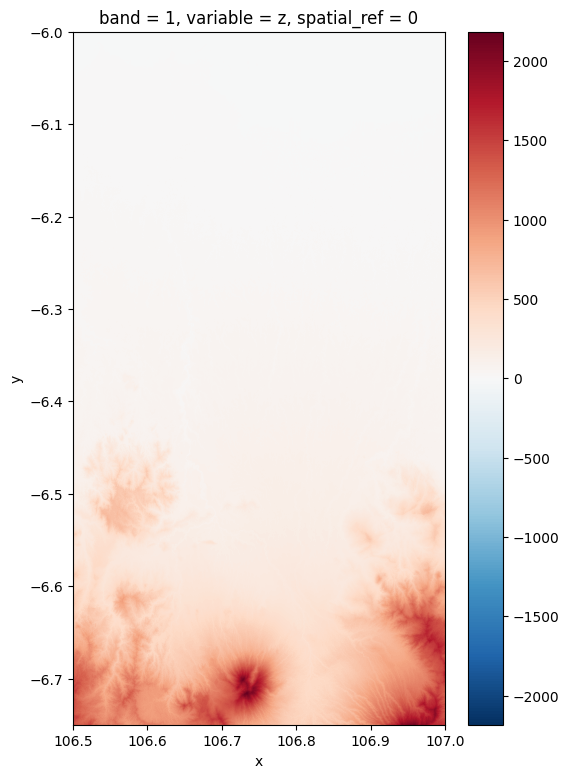

In [122]:
fig, ax = plt.subplots(figsize = (6, 9))
dem.squeeze().plot(ax = ax)

In [167]:
dem.rio.crs

CRS.from_epsg(4326)

## Step 2: Fetch coordinates of the river

To get coordinates of the river, we can use freely available [OpenStreetMap](https://www.openstreetmap.org/) data. 

Thanks to [OSMnx](https://github.com/gboeing/osmnx), we can automatically obtain a GeoPandas DataFrame from OSM data.

We thus only need to find out the river's [Way](https://wiki.openstreetmap.org/wiki/Way) ID. Using the [OSM editor](https://www.openstreetmap.org/edit), we find out it's [34406947](https://www.openstreetmap.org/way/34406947).

In [168]:
river_osm_id = [
    'w303569049',
    'w704205060',
    'w704205047',
    'w704205047',
    'w704205047',
    'w220619889',
    'w704205011',
    'w44352562',
    'w44352593',
    'w167554044',
    'w704204988',
    'w157758177',
    'w171730557',
    # 'w38121377',
    'w44354930',
    'w44355222',
    # 'w162941539'
]

river = ox.geocode_to_gdf([id.upper() for id in river_osm_id], by_osmid=True)

In [169]:
# southmost to northmost
additional_line_list = [
    -6.6538541, 106.8086060,
    -6.6535883, 106.8085736,
    -6.6532008, 106.8085013,
    -6.6529292, 106.8084060,
    -6.6526898, 106.8083190,
    -6.6525537, 106.8083591,
    -6.6522529, 106.8085313,
    -6.6519015, 106.8088169,
    -6.6515311, 106.8091215
]

# Create a LineString object
additional_line_arr = LineString(
    np.array(additional_line_list)
    .reshape(9,2)
    [:, ::-1]
    )

# Create a GeoDataFrame with the LineString
additional_line_gdf = gpd.GeoDataFrame(geometry=[additional_line_arr])

# fill in the attributes
additional_line_gdf['osm_id'] = '38121377'
additional_line_gdf['class'] = 'waterway'
additional_line_gdf['type'] = 'river'
bounds_col = additional_line_gdf.bounds.columns
bbox_col = ['bbox_north', 'bbox_south', 'bbox_east', 'bbox_west']
for bound, bbox in zip(bounds_col, bbox_col):
    additional_line_gdf[bbox] = additional_line_gdf.bounds[bound]

In [170]:
river = pd.concat([river, additional_line_gdf], ignore_index=True)

d:\0_amri_local\99_personal\REM-xarray\rem-tutorial\Lib\site-packages\geopandas\array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


### Check the cross-section profile of the river

In [171]:
# create a line object by combining all the river
line = gpd.GeoDataFrame(geometry=[linemerge(unary_union(river.geometry))]).geometry.iloc[0]
cross_section = dem.rio.clip([line])

# get the river_elev by accessing the 'variable' and convert to np array
river_elev = cross_section.variable.to_numpy()

# Create a boolean mask of non-null values
mask = ~np.isnan(river_elev)

# Apply the mask to filter out the null records
filtered_data = river_elev[mask]

Text(1139.5965793628798, 0.5, 'Latitude')

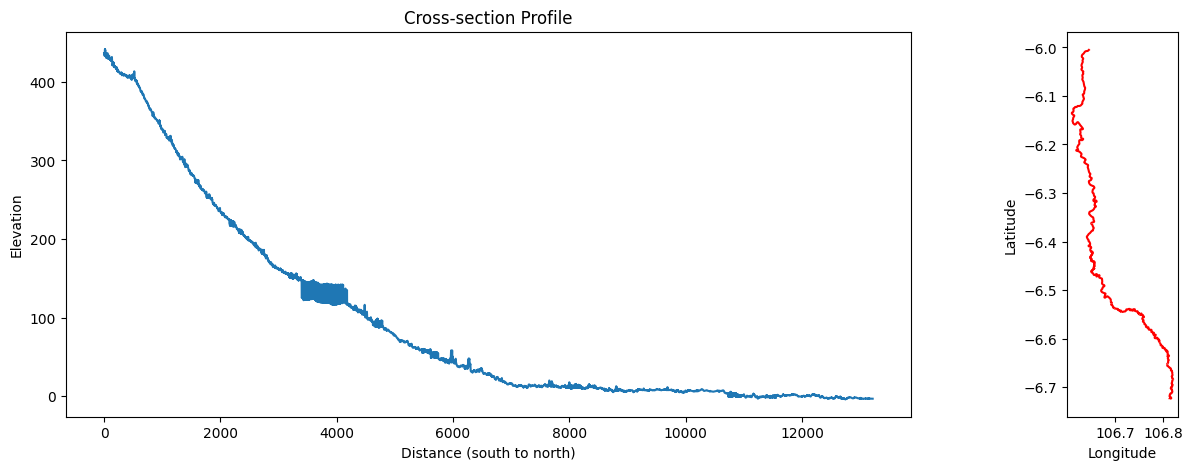

In [192]:
fig, axs = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios':[4,1]}, figsize = (15,5))

axs[0].plot(range(0,len(filtered_data))[::-1], filtered_data)
axs[0].set_xlabel("Distance (south to north)")
axs[0].set_ylabel("Elevation")
axs[0].set_title("Cross-section Profile")

river.plot(ax = axs[1], color = 'red')
axs[1].set_xlabel("Longitude")
axs[1].set_ylabel("Latitude")

In [173]:
river.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Step 3: Cut to area of interest

In [174]:
# # clip using river
# BUFFER_RADIUS = 100
# river_on_dem = river.clip(dem.rio.bounds())
# xmin, ymin, xmax, ymax = projected_buffer(river_on_dem, 100).total_bounds

# # clip using administrative boundary
# polygon_clip = ox.geocode_to_gdf("Bogor, Indonesia")
# xmin, ymin, xmax, ymax = (
#     projected_buffer(gpd.GeoDataFrame(geometry = polygon_clip.envelope), 2000)
#     .total_bounds
# )

# # clip using custom polygon
polygon_clip = Polygon([[106.780001613, -6.6098877894], [106.7999572481, -6.6098877894], [106.7999572481, -6.5949244042], [106.780001613, -6.5949244042], [106.780001613, -6.6098877894]])
polygon_clip = gpd.GeoDataFrame(geometry=[polygon_clip], crs = ORIGINAL_CRS)
xmin, ymin, xmax, ymax = (
    projected_buffer(polygon_clip, 3000)
    .total_bounds
)

# # clip using dem
# xmin, ymin, xmax, ymax = dem.rio.bounds()

bounds = box(xmin,ymin,xmax,ymax)

#### River

In [175]:
river_clipped = (
    gpd.GeoDataFrame(geometry=[linemerge(unary_union(river.geometry))])  # make a linestring from multiple line of the river
    .clip(bounds, keep_geom_type=True)
)
river_geom = river_clipped.geometry.iloc[0]

#### DEM

In [176]:
dem = dem.sel(y=slice(ymax, ymin), x=slice(xmin, xmax))

Let's check if everything looks good

<Axes: title={'center': 'band = 1, variable = z, spatial_ref = 0'}, xlabel='x', ylabel='y'>

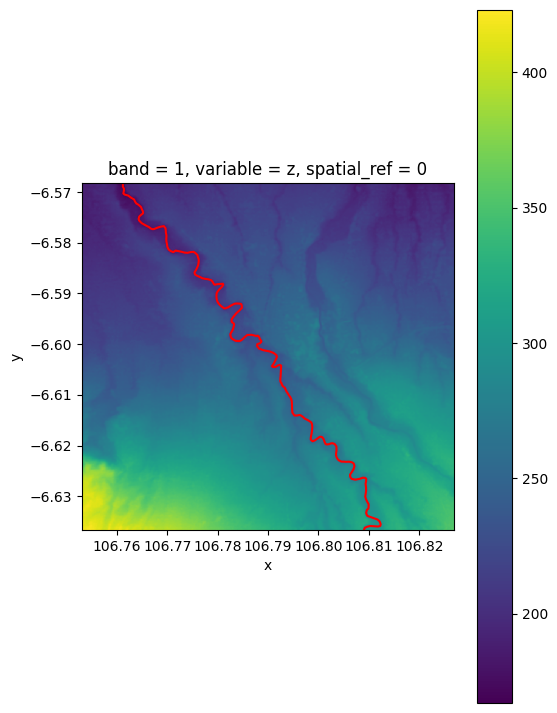

In [177]:
fig, ax = plt.subplots(figsize = (6,9))

dem.squeeze().plot(ax = ax)
river.plot(ax=ax, color='red')

## Step 4: Calculate REM

To calculate the REM, we need to 
1. Sample the elevation along the river
2. Interpolate the sampled elevation values to create a 2D elevation raster
3. Subtract the interpolated elevation raster from the DEM

### 4.1. Sample

Extract coordinates as `DataArray`

In [178]:
xs, ys = river_geom.xy
xs, ys = xr.DataArray(xs, dims='z'), xr.DataArray(ys, dims='z')

Use xarray's [`interp`](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.interp.html#xarray.DataArray.interp) to extract the river's elevation.

In [179]:
sampled = dem.interp(x=xs, y=ys, method='nearest').dropna(dim='z')

### 4.2. Interpolate

Prepare data for the interpolation

In [180]:
# Sampled river coordinates
c_sampled = np.vstack([sampled.coords[c].values for c in ('x', 'y')]).T

# All (x, y) coordinates of the original DEM
c_x, c_y = [dem.coords[c].values for c in ('x', 'y')]
c_interpolate = np.dstack(np.meshgrid(c_x, c_y)).reshape(-1, 2)

# Sampled values
values = sampled.values.ravel()

Perform the interpolation. Here we use a simple implementation of [IWD](https://en.wikipedia.org/wiki/Inverse_distance_weighting) which averages the 5 nearest points, weighted by inverse distance.

In [181]:
tree = KDTree(c_sampled)

In [182]:
# IWD interpolation
distances, indices = tree.query(c_interpolate, k=5)

weights = 1 / distances
weights = weights / weights.sum(axis=1).reshape(-1, 1)

interpolated_values = (weights * values[indices]).sum(axis=1)

We create a `DataArray` out of the inerpolated values

In [183]:
elevation_raster = xr.DataArray(
    interpolated_values.reshape((len(c_y), len(c_x))).T, dims=('x', 'y'), coords={'x': c_x, 'y': c_y}
)

<Axes: xlabel='x', ylabel='y'>

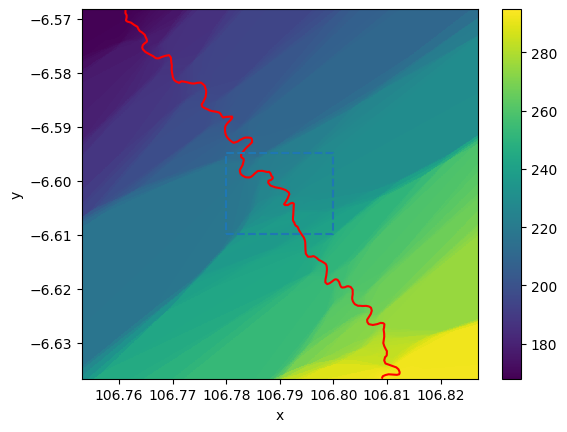

In [184]:
fig, ax = plt.subplots()
elevation_raster.transpose().plot.imshow(ax=ax)
river_clipped.plot(ax=ax, color='red')
polygon_clip.boundary.plot(ax=ax, ls = '--')

### 4.3. Calculate

In [185]:
rem = dem - elevation_raster

# Step 5: Visualize

Let's make some pretty REM visualizations!

In [186]:
colors = ['#f2f7fb', '#81a8cb', '#37123d']

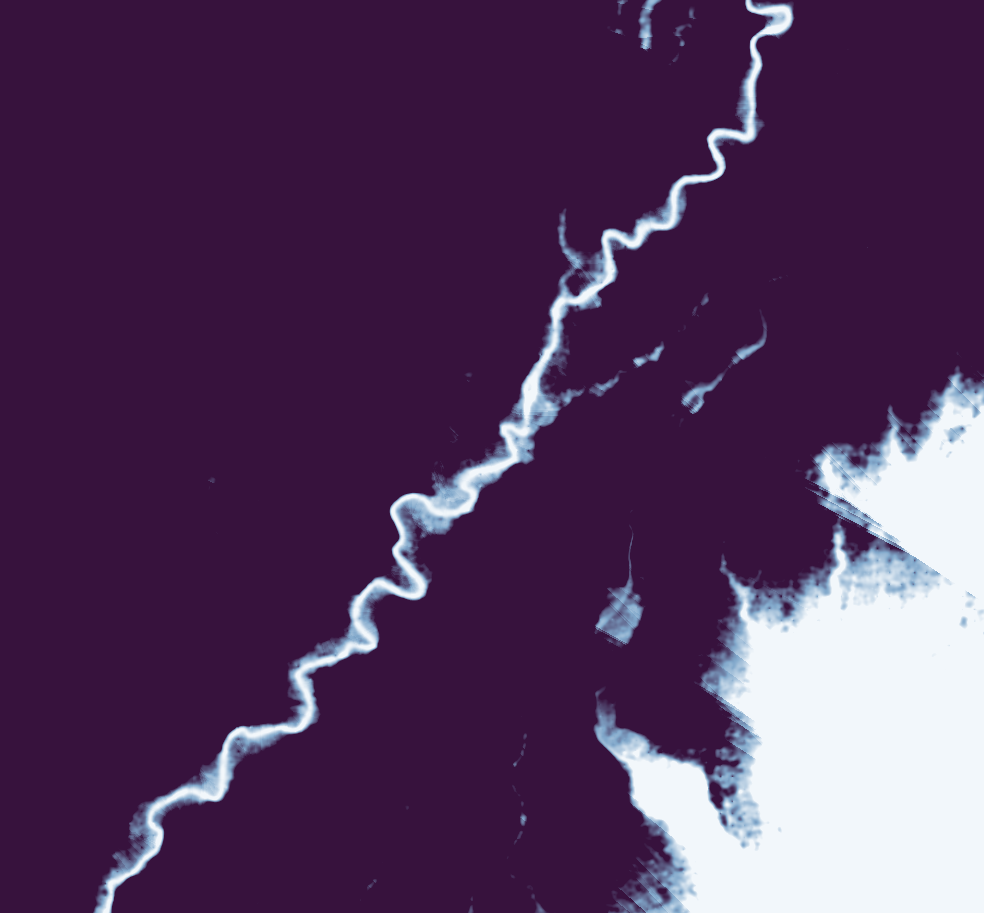

In [187]:
img = shade(rem.squeeze(), cmap=colors, span=[0, 10], how='linear')
# Images(img)
export_image(img, "out", background="black", export_path=".")

We can also visualize the DEM along with the REM

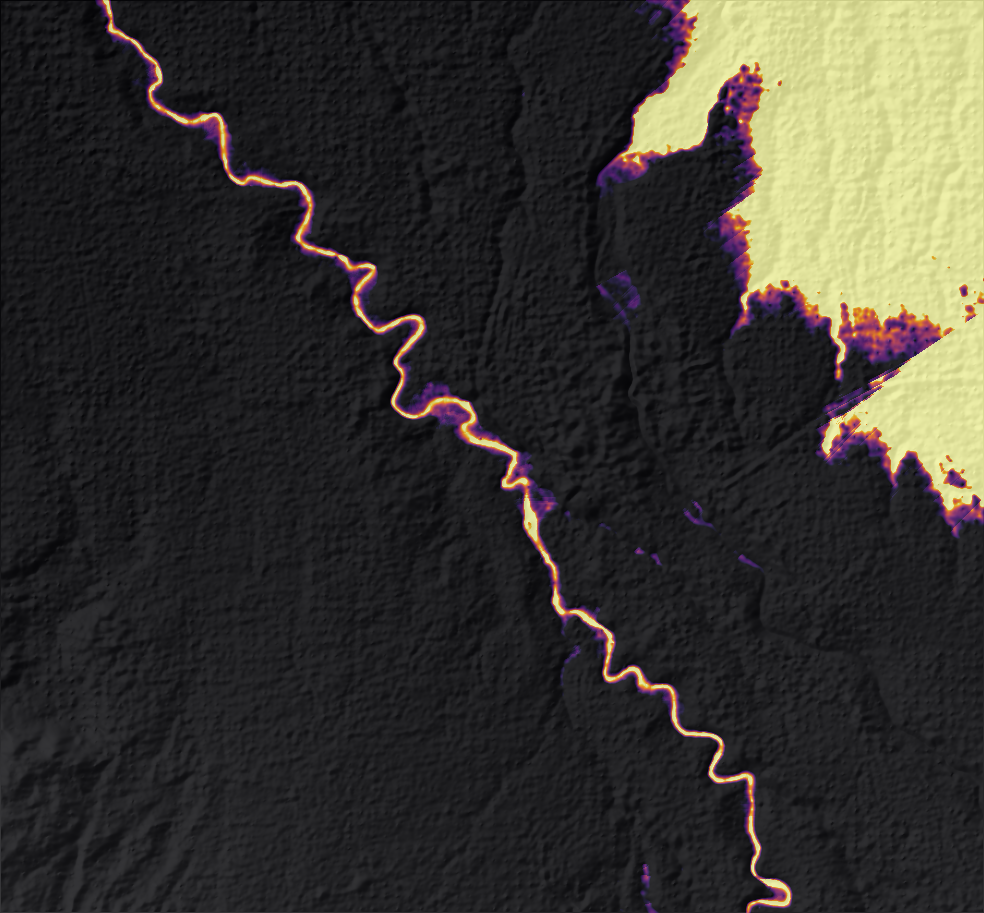

In [191]:
illuminated = xrspatial.hillshade(dem.squeeze(), angle_altitude=1, azimuth=310)
img = stack(
    shade(dem.squeeze(), cmap=Greys9, how="linear"),
    shade(illuminated, cmap=["black", "white"], how="linear", alpha=180),
    shade(rem.squeeze(), cmap=inferno[::-1], span=[0, 7], how="log", alpha=200),
)

export_image(img[::-1], 'out')